![](https://github.com/rajeevratan84/ModernComputerVision/raw/main/logo_MCV_W.png)

# **Facial Similarity Using PyTorch**
### **Using MTCNN for Facial Detection**

![](https://github.com/timesler/facenet-pytorch/raw/master/data/facenet-pytorch-banner.png)

---




In this lesson, we learn use the **FaceNet-PyTorch** module to perform simple face detection, similarity and recognition. 
1. Clone the repo and install `facenet-pytorch`
2. Load our modules and data
3. Perfom (Multi-task Cascaded Convolutional Networks) MTCNN facial recognition


**Notes:**

This is a repository for Inception Resnet (V1) models in pytorch, pretrained on VGGFace2 and CASIA-Webface.

Pytorch model weights were initialized using parameters ported from David Sandberg's tensorflow facenet repo.

Also included in this repo is an efficient pytorch implementation of MTCNN for face detection prior to inference. These models are also pretrained. To our knowledge, this is the fastest MTCNN implementation available.

https://github.com/timesler/facenet-pytorch#guide-to-mtcnn-in-facenet-pytorch

## **1. Clone the repo and install facenet-pytorch**

In [12]:
!git clone https://github.com/timesler/facenet-pytorch.git

fatal: destination path 'facenet-pytorch' already exists and is not an empty directory.


In [ ]:
pip install facenet-pytorch

     |████████████████████████████████| 1.9 MB 8.3 MB/s 


## **2. Load our modules and data**

The following example illustrates how to use the facenet_pytorch python package to perform face detection and recogition on an image dataset using an Inception Resnet V1 pretrained on the VGGFace2 dataset.

The following Pytorch methods are included:

Datasets
Dataloaders
GPU/CPU processing

In [13]:
from facenet_pytorch import MTCNN, InceptionResnetV1
import torch
from torch.utils.data import DataLoader
from torchvision import datasets
import numpy as np
import pandas as pd
import os

workers = 0 if os.name == 'nt' else 4

In [ ]:
# Determine if an nvidia GPU is available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))

Running on device: cpu


**Define MTCNN module**

Default params shown for illustration, but not needed. Note that, since MTCNN is a collection of neural nets and other code, the device must be passed in the following way to enable copying of objects when needed internally.

See help(MTCNN) for more details.

In [ ]:
mtcnn = MTCNN(
    image_size=160, margin=0, min_face_size=20,
    thresholds=[0.6, 0.7, 0.7], factor=0.709, post_process=True,
    device=device)

**Define Inception Resnet V1 module**

Set classify=True for pretrained classifier. For this example, we will use the model to output embeddings/CNN features. Note that for inference, it is important to set the model to eval mode.

See help(InceptionResnetV1) for more details.

In [ ]:
resnet = InceptionResnetV1(pretrained='vggface2').eval().to(device)

  0%|          | 0.00/107M [00:00<?, ?B/s]

**Define a dataset and data loader**

We add the idx_to_class attribute to the dataset to enable easy recoding of label indices to identity names later one.

In [ ]:
def collate_fn(x):
    return x[0]

dataset = datasets.ImageFolder('facenet-pytorch/data/test_images')
dataset.idx_to_class = {i:c for c, i in dataset.class_to_idx.items()}
loader = DataLoader(dataset, collate_fn=collate_fn, num_workers=workers)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


### **View our images**

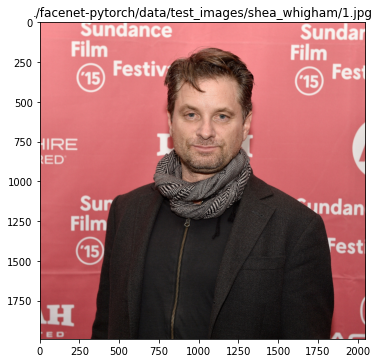

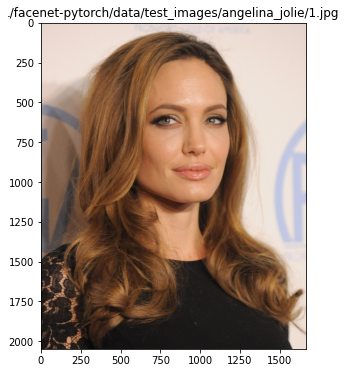

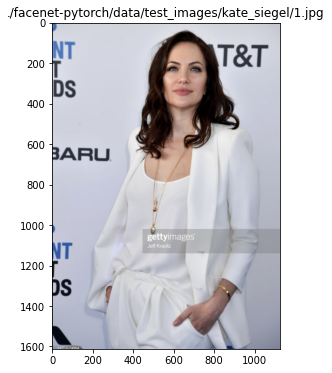

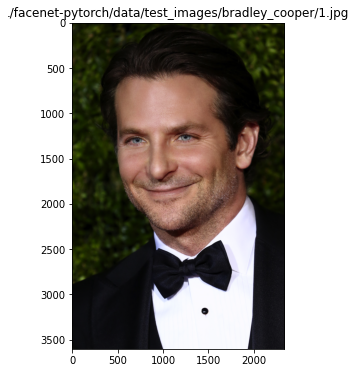

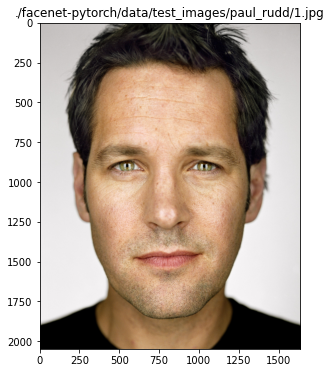

In [ ]:
import glob
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Define our imshow function 
def imgshow(title="", image = None, size = 6):
    if image.any():
      w, h = image.shape[0], image.shape[1]
      aspect_ratio = w/h
      plt.figure(figsize=(size * aspect_ratio,size))
      plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
      plt.title(title)
      plt.show()
    else:
      print("Image not found")


for f in glob.glob('./facenet-pytorch/data/test_images/**/*.jpg', recursive=True):
    image = cv2.imread(f)
    imgshow(f, image)

## **3. Perfom MTCNN facial detection**

Iterate through the DataLoader object and detect faces and associated detection probabilities for each. The MTCNN forward method returns images cropped to the detected face, if a face was detected. By default only a single detected face is returned - to have MTCNN return all detected faces, set keep_all=True when creating the MTCNN object above.

To obtain bounding boxes rather than cropped face images, you can instead call the lower-level mtcnn.detect() function. See help(mtcnn.detect) for details.

In [ ]:
aligned = []
names = []

for x, y in loader:
    x_aligned, prob = mtcnn(x, return_prob=True)
    if x_aligned is not None:
        print('Face detected with probability: {:8f}'.format(prob))
        aligned.append(x_aligned)
        names.append(dataset.idx_to_class[y])

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Face detected with probability: 0.999983
Face detected with probability: 0.999934
Face detected with probability: 0.999733
Face detected with probability: 0.999880
Face detected with probability: 0.999992


**Calculate image embeddings**

MTCNN will return images of faces all the same size, enabling easy batch processing with the Resnet recognition module. Here, since we only have a few images, we build a single batch and perform inference on it.

For real datasets, code should be modified to control batch sizes being passed to the Resnet, particularly if being processed on a GPU. For repeated testing, it is best to separate face detection (using MTCNN) from embedding or classification (using InceptionResnetV1), as calculation of cropped faces or bounding boxes can then be performed a single time and detected faces saved for future use.

In [ ]:
aligned = torch.stack(aligned).to(device)
embeddings = resnet(aligned).detach().cpu()

**Print distance matrix for classes**

In [ ]:
dists = [[(e1 - e2).norm().item() for e2 in embeddings] for e1 in embeddings]
pd.DataFrame(dists, columns=names, index=names)

,angelina_jolie,bradley_cooper,kate_siegel,paul_rudd,shea_whigham
angelina_jolie,0.000000,1.447480,0.887728,1.429847,1.399073
bradley_cooper,1.447480,0.000000,1.313749,1.013447,1.038684
kate_siegel,0.887728,1.313749,0.000000,1.388377,1.379654
paul_rudd,1.429847,1.013447,1.388377,0.000000,1.100503
shea_whigham,1.399073,1.038684,1.379654,1.100503,0.000000
